In [35]:
from dataset import get_datasets

train_dataset, test_dataset = get_datasets()

In [9]:
import pandas as pd
import torch.nn as nn
from torchvision import models
from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
alexnet = models.alexnet(pretrained=True)
last_layer_classifier = nn.Sequential(
    nn.Linear(9216, len(df.columns) - 2), nn.Sigmoid()
)

/Users/yslomichael/opt/anaconda3/envs/stat4012proj/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yslomichael/opt/anaconda3/envs/stat4012proj/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import wandb

PROJECT_NAME = "STAT4012Project"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yatshingl (cuhkstat4012proj). Use `wandb login --relogin` to force relogin


True

In [5]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from torch import optim
from model import pretrainedModel
import time

config = {
    "batch_size": 32,
    "loss_fn": nn.BCELoss,
    "lr": 0.000001,
    "optimizer": optim.Adam,
    "epochs": 5,
}

model_alexnet_1 = pretrainedModel(
    alexnet,
    last_layer_classifier,
    len(df.columns) - 2,
    config["loss_fn"],
    config["optimizer"],
    lr=config["lr"],
)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
validation_loader = DataLoader(
    test_dataset, batch_size=config["batch_size"], shuffle=False
)

run_name = "alexnet_1_" + str(int(time.time()))
logger = WandbLogger(name=run_name, project=PROJECT_NAME, log_model="all")
trainer = L.Trainer(max_epochs=config["epochs"], logger=logger)

trainer.fit(model_alexnet_1, train_loader, validation_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name             | Type            | Params
-----------------------------------------------------
0 | features         | Sequential      | 2.5 M 
1 | class_classifier | Sequential      | 175 K 
2 | loss_fn          | BCELoss         | 0     
3 | metrics          | MultilabelAUROC | 0     
-----------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.579    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yslomichael/opt/anaconda3/envs/stat4012proj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/yslomichael/opt/anaconda3/envs/stat4012proj/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/yslomichael/opt/anaconda3/envs/stat4012proj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Model Evaluation

In [38]:
import os
from model import pretrainedModel
import pandas as pd
from torchvision import models
import torch.nn as nn
from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
alexnet = models.alexnet()
last_layer_classifier = nn.Sequential(
    nn.Linear(9216, len(df.columns) - 2), nn.Sigmoid()
)

alexnet_1_1712830034_trained = pretrainedModel.load_from_checkpoint(
    os.path.join("AlexNet", "AlexNet_checkpoint", "epoch=4-step=68605.ckpt"),
    pre_trained_model=alexnet,
    last_layer_classifier=last_layer_classifier,
    num_labels=len(df.columns) - 2,
)

In [8]:
import lightning as L
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset import PosterDataset

all_data = PosterDataset()
all_dataloader = DataLoader(
    all_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True
)

trainer = L.Trainer()
predictions = trainer.predict(alexnet_1_1712830034_trained, all_dataloader)
all_prediction = np.concatenate(predictions)
prediction_filename = "alexnet_predictions.npz"
np.savez_compressed(prediction_filename, all_prediction)

ModuleNotFoundError: No module named 'dataset'

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_prediction = np.load("alexnet_predictions.npz")["arr_0"]
train_indices, test_indices = train_test_split(
    np.arange(len(all_prediction)), test_size=0.2, random_state=42
)


def evaluate_auroc(y_true, y_pred):
    # Calculate ROC AUC for each label
    roc_auc_scores = {}
    for i in range(y_true.shape[1]):  # Iterate over each label
        roc_auc_scores[df.columns[i + 1][1:]] = roc_auc_score(
            y_true[:, i], y_pred[:, i]
        )

    # Print ROC AUC scores for each label
    results = pd.DataFrame(roc_auc_scores.items(), columns=["Genre", "ROC AUC"])
    print(results)
    # Calculate the average ROC AUC score across all labels
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC: {average_roc_auc:.4f}")

    # Plot the ROC curve
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=df.columns[i + 1][1:])
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multilabel ROC curve")
    plt.legend()
    plt.show()

              Genre   ROC AUC
0            Action  0.771057
1         Adventure  0.722933
2         Animation  0.876566
3            Comedy  0.726734
4             Crime  0.690228
5       Documentary  0.758887
6             Drama  0.664831
7            Family  0.755334
8           Fantasy  0.660555
9           History  0.647641
10           Horror  0.817922
11            Music  0.668547
12          Mystery  0.657346
13          Romance  0.725943
14  Science Fiction  0.726736
15         TV Movie  0.697620
16         Thriller  0.746593
17              War  0.710640
18          Western  0.835251
Average ROC AUC: 0.7295


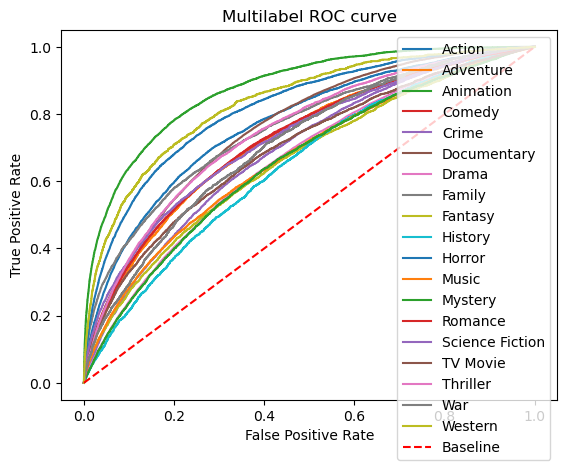

In [33]:
test_true = df.iloc[test_indices, 1:-1].to_numpy().astype(np.float32)
test_predictions = all_prediction[test_indices]
evaluate_auroc(test_true, test_predictions)

              Genre   ROC AUC
0            Action  0.777691
1         Adventure  0.735384
2         Animation  0.879263
3            Comedy  0.731931
4             Crime  0.700677
5       Documentary  0.762662
6             Drama  0.673277
7            Family  0.761506
8           Fantasy  0.674063
9           History  0.657761
10           Horror  0.817697
11            Music  0.685385
12          Mystery  0.675258
13          Romance  0.733802
14  Science Fiction  0.731714
15         TV Movie  0.710196
16         Thriller  0.751413
17              War  0.714052
18          Western  0.844992
Average ROC AUC: 0.7378


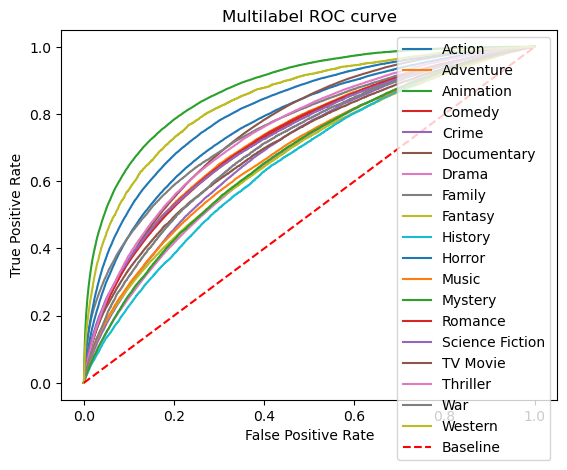

In [34]:
train_true = df.iloc[train_indices, 1:-1].to_numpy().astype(np.float32)
train_predictions = all_prediction[train_indices]

evaluate_auroc(train_true, train_predictions)

In [37]:
import pickle

# Save the model to a pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(alexnet_1_1712830034_trained, f)

In [39]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from PIL import Image
import torch

from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)


def predict_image(*args, plot=False):
    img = np.asarray(Image.open(*args))[:, :, :3]
    if plot:
        plt.imshow(img)
        plt.show()
    img = PosterDataset.get_default_transform()(img)
    alexnet_1_1712830034_trained.eval()
    with torch.no_grad():
        predictions = alexnet_1_1712830034_trained(img.unsqueeze(0)).flatten().numpy()
    rounded_predictions = np.round(predictions, 2)
    df_predictions = pd.DataFrame(
        list(zip([genre[1:] for genre in df.columns[1:-1]], rounded_predictions)),
        columns=["Genre", "Probability"],
    )
    return df_predictions

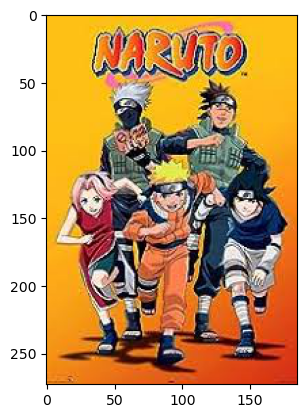

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Probability,0.09,0.2,0.19,0.56,0.05,0.04,0.1,0.09,0.04,0.02,0.0,0.12,0.01,0.05,0.04,0.01,0.01,0.01,0.07


In [49]:
predict_image("img/naruto.jpeg", plot=True).T